# Models 

- only a|a|a or b|b|b
- only morning
- only SVM linear

In [168]:
import sys
import os as os
import numpy as np
try:
    import cPickle as pickle
except:
    import pickle as pkl

import scipy as scipy
import scipy.io as spio
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import signal
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.io.matlab import mat_struct
import pickle
import random
random.seed(666)

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=True, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], scipy.io.matlab.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, scipy.io.matlab.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

## Load session data

In [169]:
meta = {}
meta[21] = {'mouse':'3C290', 'ks':'Kilosort_2024-05-15_180443', 'del_units':None, 'vis_mice':np.array(['beta1', 'beta2', 'beta3']), 'active_blocks' : [1,2,3]}
meta[22] = {'mouse':'3C290', 'ks':'Kilosort_2024-05-08_160558', 'del_units':None, 'vis_mice':np.array(['alpha1', 'alpha2', 'alpha3']), 'active_blocks' : [0,1,2]}


In [170]:
Session = 22

In [171]:
mouse = meta[Session]['mouse']
ks = meta[Session]['ks']
del_units=meta[Session]['del_units']
vis_mice = meta[Session]['vis_mice']
active_blocks = meta[Session]['active_blocks']

In [172]:
idx1 = active_blocks[0]
idx2 = active_blocks[1]
idx3 = active_blocks[2]

In [173]:
# create folder to save results
try:
    os.makedirs(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\aaa_bbb')
except:
    pass

### Ephys data

In [174]:
KSdir = f'L:\\everyone\\sharedDATA\\ProcessedDATA\\{mouse}\\{mouse}_S{Session}\\{ks}\\'

spiketimesfile = KSdir+"spike_times.npy"  
spiketimes = np.load(spiketimesfile)  #### all spiketimes as indexes regardless of cluster

clusterfile = KSdir+"spike_clusters.npy"
spikeclusters = np.load(clusterfile) #### cluster id for each detected spike

Clusterinfofile = KSdir+"cluster_info.tsv"
Clusterinfo = pd.read_csv(Clusterinfofile,sep='\t') #### cluster meta-data matrix

In [175]:
goodclusts = Clusterinfo['cluster_id'][np.where(Clusterinfo['group']=='good')[0]]
goods = []
for clust in goodclusts :
    goods.append(clust)
print(f'Session {Session}: {len(goods)} good clusters')

Session 22: 26 good clusters


In [176]:
goodspiketimes = {}

spikethresh = 1000 # min nb of spikes
for goodunit in goods :
    goodinds = np.where(spikeclusters==goodunit)[0]
    if goodinds.shape[0] > spikethresh : 
        goodspiketimes[goodunit] = spiketimes[goodinds]

In [177]:
len(goodspiketimes.keys())

18

### Behavior data

In [178]:
matfile =  f'L:\\everyone\\sharedDATA\\ProcessedDATA\\{mouse}\\{mouse}_S{Session}\\Behaviour.mat'
EvaBehavior = loadmat(matfile)

In [179]:
def load_behavioral_event(event_idx, time_to_idx = True):
    '''
    returns dictionary; keys - blocks; inside - array with event :
    time stamps in [sec] if time_to_idx = False
    indexes if time_to_idx = True
    '''
    event_dic = {}

    for block in np.arange(EvaBehavior['Behaviour'].shape[0]) :
        if time_to_idx:
            event_dic[block] = EvaBehavior['Behaviour'][block][event_idx]*20000
        else:
            event_dic[block] = EvaBehavior['Behaviour'][block][event_idx]
        event_dic[block] = event_dic[block].astype(int)
    
    return event_dic

In [180]:
TestSocialSampleWindowPerTrial = load_behavioral_event(12)

## Data prep: firing rate array

In [181]:
import copy

In [182]:
def fr_matrix_prep(beforesamples, aftersamples, blocks, bins, del_units=None):
    # discard wierd cells based on rasters
    goodspiketimes_copy = copy.deepcopy(goodspiketimes)

    try:
        for unit in del_units:
            del goodspiketimes_copy[unit]
    except:
        pass

    units = goodspiketimes_copy.keys()
    fr_dic = {}
   
    for block in blocks:
        n_trials = TestSocialSampleWindowPerTrial[block].shape[0]
        n_units = len(goodspiketimes_copy.keys())

        fr_matrix = np.zeros((n_trials, n_units))

        i = 0
        for unit in units: # list of good cluster_id
            
            
            for event in np.arange(TestSocialSampleWindowPerTrial[block].shape[0]) : #iterate by npoke events

                onset = TestSocialSampleWindowPerTrial[block][event,0]
                offset = TestSocialSampleWindowPerTrial[block][event,1]
                
                cond1 = np.where(goodspiketimes_copy[unit].astype(int)>=onset-beforesamples)[0]
                cond2 = np.where(goodspiketimes_copy[unit].astype(int)<=offset+aftersamples)[0]
                unitspikes = goodspiketimes_copy[unit][np.intersect1d(cond1,cond2)].astype(int)-onset

                n = np.histogram(unitspikes, bins=bins)[0][0]
                fr = n/0.25
                fr_matrix[event, i] = fr
            i+=1
                
        fr_dic[block] = fr_matrix
    
    return fr_dic
        

### Firing rates

firing rate [Hz] = spike_count/ time_window(sec)

* lets find it for each trial for each cell
* we will make an array where each row is trial; each column - neuron; we will collect it in dict where keys = blocks

In [183]:
## find spikes in interesting behavioral window
samplplimg_rate = 20*1000 #20 kHz
beforesamples = 0*samplplimg_rate # 1 sec (expressed in samples for a 20khz sampling rate)
aftersamples = 0*samplplimg_rate # 1 sec
npoke_window = 0.25
eventlength = npoke_window*samplplimg_rate # 0.25 s

binsize = 0.25*samplplimg_rate 
bins = np.linspace(-beforesamples,aftersamples+eventlength,int((beforesamples+aftersamples+eventlength)/binsize)+1)

In [184]:
# 250 ms during the nosepoke
fr_dic = fr_matrix_prep(beforesamples, aftersamples, blocks=active_blocks, bins=bins, del_units=del_units)

In [185]:
fr_dic.keys()

dict_keys([0, 1, 2])

In [186]:
fr_dic[1].shape

(30, 18)

## PCA

In [187]:
from scipy.stats import multivariate_normal
import matplotlib.patches as patches
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [188]:
n_clusters=3
firing_rates_concat = np.concatenate((fr_dic[idx1], fr_dic[idx2], fr_dic[idx3]),axis=0)

In [189]:
# Standardize the data
scaler = StandardScaler() # z-scoring (x-mean)/sd
scaled_data = scaler.fit_transform(firing_rates_concat)

# Apply PCA
pca = PCA(n_components=2)  # Choose number of components based on explained variance
principal_components = pca.fit_transform(scaled_data)

# Scale each principal component to range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))
principal_components = scaler.fit_transform(principal_components)  

In [190]:
principal_components.shape

(90, 2)

In [191]:
k = int(principal_components.shape[0]/n_clusters)

a_pca = principal_components[:k,:]
b_pca = principal_components[k:k+k,:]
c_pca = principal_components[k+k:,:]

centroidd_a_pca = np.mean(a_pca, axis=0).reshape(1, -1)[0]
centroidd_b_pca = np.mean(b_pca, axis=0).reshape(1, -1)[0]
centroidd_c_pca = np.mean(c_pca, axis=0).reshape(1, -1)[0]

a_pca.shape, b_pca.shape, c_pca.shape, centroidd_a_pca.shape

((30, 2), (30, 2), (30, 2), (2,))

In [192]:
def fit_gaussian(data):
    """Fit a 2D Gaussian to the data and return the mean and covariance."""
    mean = np.mean(data, axis=0)
    cov = np.cov(data, rowvar=False)
    return mean, cov

def plot_ellipse(mean, cov, ax, n_std=1.0, color='red', **kwargs):
    """Plot an ellipse representing the Gaussian mean ± n_std * standard deviations."""
    # Eigenvalue decomposition to find the axis lengths and rotation angle
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    
    # Width and height are "full" lengths, not radius
    width, height = 2 * n_std * np.sqrt(vals)
    
    ell = patches.Ellipse(xy=mean, width=width, height=height, angle=theta, edgecolor=None, facecolor=color, alpha=0.35, **kwargs)
    ax.add_patch(ell)

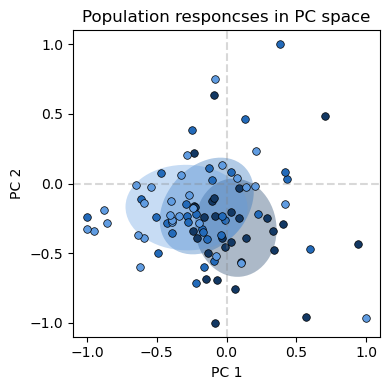

In [193]:
data_pca = [a_pca, b_pca, c_pca]
if vis_mice[0]=='alpha1':
    colors = ['#133863', '#236AB9', '#609CE1']
else:
    colors = ['#9D4502', '#FC7307', '#FEAB6D']
names = ['alpha', 'beta', 'blank']

fig, ax = plt.subplots(figsize=(4, 4))

i = 0
for data, color in zip(data_pca, colors):
    mean, cov = fit_gaussian(data)
    plot_ellipse(mean, cov, ax, color=color)
    i+=1

i = 0
for data, color in zip(data_pca, colors):
    # Plot data points
    ax.scatter(data[:, 0], data[:, 1], s=30, color=color, label=names[i], edgecolor='k',  linewidth=0.5)
    i+=1

plt.axvline(0,  linestyle = '--', color='#808080', alpha=0.3)
plt.axhline(0,  linestyle = '--', color='#808080', alpha=0.3)
# plt.grid(True)
# plt.axis('equal')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
# plt.ylim(-1,1)
# plt.xlim(-1,1)
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.title('Population responcses in PC space')
# plt.legend()
plt.tight_layout()
plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\aaa_bbb\\{mouse}_s{Session}_pca.png', dpi=300, bbox_inches='tight')
plt.show() 

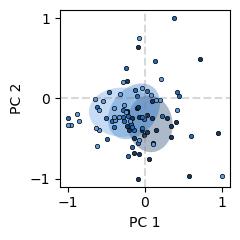

In [194]:
data_pca = [a_pca, b_pca, c_pca]
if vis_mice[0]=='alpha1':
    colors = ['#133863', '#236AB9', '#609CE1']
else:
    colors = ['#9D4502', '#FC7307', '#FEAB6D']
names = ['alpha', 'beta', 'blank']

fig, ax = plt.subplots(figsize=(2.5,2.5))

i = 0
for data, color in zip(data_pca, colors):
    mean, cov = fit_gaussian(data)
    plot_ellipse(mean, cov, ax, color=color)
    i+=1

i = 0
for data, color in zip(data_pca, colors):
    # Plot data points
    ax.scatter(data[:, 0], data[:, 1], s=10, color=color, label=names[i], edgecolor='k',  linewidth=0.5)
    i+=1

plt.axvline(0,  linestyle = '--', color='#808080', alpha=0.3)
plt.axhline(0,  linestyle = '--', color='#808080', alpha=0.3)
# plt.grid(True)
# plt.axis('equal')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
# plt.ylim(-1,1)
# plt.xlim(-1,1)
plt.xticks([-1, 0, 1])
plt.yticks([-1, 0, 1])
# plt.title('Population responcses in PC space')
# plt.legend()
plt.tight_layout()
plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\aaa_bbb\\{mouse}_s{Session}_pca_mini.png', dpi=300, bbox_inches='tight')
plt.show() 

In [195]:
from scipy.spatial.distance import mahalanobis
import scipy.stats as stats
from scipy.stats import percentileofscore
import seaborn as sns
import math

In [196]:
def calculate_distance(principal_components, n_clusters=3, MD=True):

    k = int(principal_components.shape[0]/n_clusters)

    a_pca = principal_components[:k,:]
    b_pca = principal_components[k:k+k,:]
    c_pca = principal_components[k+k:,:]

    centroid_a_pca = np.mean(a_pca, axis=0).reshape(1, -1)[0]
    centroid_b_pca = np.mean(b_pca, axis=0).reshape(1, -1)[0]
    centroid_c_pca = np.mean(c_pca, axis=0).reshape(1, -1)[0]

    if MD==True:
        covar = np.cov(principal_components.T)
        covarinv = np.linalg.inv(covar)

        # sparsity
        D_a = [mahalanobis(x, centroid_a_pca, covarinv) for x in a_pca]
        D_b = [mahalanobis(x, centroid_b_pca, covarinv) for x in b_pca]
        D_c = [mahalanobis(x, centroid_c_pca, covarinv) for x in c_pca]

        # distance bw centroids
        D_ab = mahalanobis(centroid_a_pca, centroid_b_pca, covarinv)
        D_ac = mahalanobis(centroid_a_pca, centroid_c_pca, covarinv)
        D_bc = mahalanobis(centroid_b_pca, centroid_c_pca, covarinv)

    else:
        D_a = [euclidean(x, centroid_a_pca) for x in a_pca]
        D_b = [euclidean(x, centroid_b_pca) for x in b_pca]
        D_c = [euclidean(x, centroid_c_pca) for x in c_pca]


        D_ab = euclidean(centroid_a_pca, centroid_b_pca) 
        D_ac = euclidean(centroid_a_pca, centroid_c_pca) 
        D_bc = euclidean(centroid_b_pca, centroid_c_pca)

    # assemble matrix
    D_matrix = np.zeros((3,3))
    D_matrix[0,0] = np.mean(np.array(D_a))
    D_matrix[0,1] = D_ab
    D_matrix[0,2] = D_ac

    D_matrix[1,0] = np.nan
    D_matrix[1,1] = np.mean(np.array(D_b))
    D_matrix[1,2] = D_bc


    D_matrix[2,0] = np.nan
    D_matrix[2,1] = np.nan
    D_matrix[2,2] = np.mean(np.array(D_c))
    
    
    return D_matrix

In [197]:
def plot_distance_matrix(D_matrix, D_type = "MD", rotate=False):
    plt.figure(figsize=(2, 1.5))

    labels = ['Alpha', 'Beta', 'Blank']

    if D_type=='MD':
        cbar_label = 'Mahalanobis distance'
    else:
        cbar_label = 'Euclidean distance'

    if rotate:
        # Create the heatmap
        heatmap = sns.heatmap(D_matrix, annot=D_matrix, cmap='binary', cbar_kws={'label': cbar_label}, linewidths=1, linecolor='white', square=True, vmin=0, vmax=math.sqrt(8))

        # # Customize the heatmap
        heatmap.set_xticklabels(labels, rotation=0)
        heatmap.set_yticklabels(labels, rotation=90)

        cbar = heatmap.collections[0].colorbar
        cbar.ax.tick_params(rotation=90)

    else:
        # Create the heatmap
        sns.heatmap(D_matrix, annot=D_matrix, cmap='binary', cbar_kws={'label': cbar_label}, linewidths=1, linecolor='white', square=True, vmin=0, vmax=math.sqrt(8))

        # # Customize the heatmap
        plt.xticks(ticks=np.arange(len(labels))+0.5, labels=labels, rotation=0)
        plt.yticks(ticks=np.arange(len(labels))+0.5, labels=labels, rotation=90)

    plt.title('Distance in PC space\n')
    plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\aaa_bbb\\{mouse}_S{Session}_{D_type}_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

In [198]:
MD_matrix = calculate_distance(principal_components)

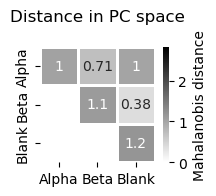

In [199]:
plot_distance_matrix(MD_matrix)

## Classifiers

In [148]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from scipy.stats import percentileofscore
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [149]:
# data prep
data1 = fr_dic[idx1]
data2 = fr_dic[idx2]
data3 = fr_dic[idx3]

# random.seed(666)

num_rows = data1.shape[0]
shuffled_indices = list(range(num_rows))

random.shuffle(shuffled_indices)
data1 = data1[shuffled_indices]

random.shuffle(shuffled_indices)
data2 = data2[shuffled_indices]

random.shuffle(shuffled_indices)
data3 = data3[shuffled_indices]


data1.shape, data2.shape, data3.shape

((30, 20), (30, 20), (30, 20))

### SVC

In [150]:
def SVM(alpha_data, beta_data, kernel = 'linear', cv=5):

    # random.seed(666)
    # params
    num_rows = alpha_data.shape[0]
    indices = list(range(num_rows))
    train_proportion = 6 # out of 30 trials

    # collect outcomes
    accuracy_cv5 = []

    for n in range(cv):
        test_alpha_idx = random.sample(indices, train_proportion)
        train_alpha_idx = [number for number in indices if number not in test_alpha_idx]
        test_alpha = alpha_data[test_alpha_idx]
        train_alpha = alpha_data[train_alpha_idx]

        test_beta_idx = random.sample(indices, train_proportion)
        train_beta_idx = [number for number in indices if number not in test_beta_idx]
        test_beta = beta_data[test_beta_idx]
        train_beta = beta_data[train_beta_idx]

        test_ab = np.concatenate((test_alpha,test_beta), axis=0)
        train_ab = np.concatenate((train_alpha,train_beta), axis=0)

        # Standardize the data
        scaler = StandardScaler()
        test_ab = scaler.fit_transform(test_ab)
        train_ab = scaler.fit_transform(train_ab)

        y_test = np.concatenate((np.ones(test_alpha.shape[0]),np.zeros(test_beta.shape[0])))
        y_train = np.concatenate((np.ones(train_alpha.shape[0]),np.zeros(train_beta.shape[0])))

        # randomize train
        num_rows = train_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        train_ab = train_ab[shuffled_indices]
        y_train = y_train[shuffled_indices]

        svm_classifier_cv = SVC(kernel=kernel, random_state=666)
        svm_classifier_cv.fit(train_ab, y_train)
        y_pred = svm_classifier_cv.predict(test_ab)
        accuracy_cv5.append(accuracy_score(y_test, y_pred)) 

    return np.mean(np.array(accuracy_cv5)) 

In [151]:
acc_svm_12 = SVM(data1, data2)
acc_svm_13 = SVM(data1, data3)
acc_svm_23 = SVM(data2, data3)

acc_svm_12, acc_svm_13, acc_svm_23

(0.5333333333333333, 0.55, 0.4833333333333334)

In [152]:
acc_svm = [acc_svm_12,acc_svm_23,acc_svm_13]

In [153]:
# shuffle
acc_sh12 = []
acc_sh23 = []
acc_sh13 = []


shuffled_indices = list(range(len(data1)*3))
for sh in range(1000):
    # data prep
    data_123 = np.concatenate((data1,data2,data3), axis=0)
    random.shuffle(shuffled_indices)
    data_123 = data_123[shuffled_indices]
    k = data1.shape[0]
    sh1 = data_123[:k]
    sh2 = data_123[k:k*2]
    sh3 = data_123[k*2:]
    
    acc_sh12.append(SVM(sh1, sh2))
    acc_sh13.append(SVM(sh1, sh3))
    acc_sh23.append(SVM(sh2, sh3))
    

In [154]:
acc_sh = [acc_sh12,acc_sh23,acc_sh13]

In [155]:
pvals = []
for i in range(3):
    acc_sh_sorted = np.sort(np.array(acc_sh[i]))
    percentile_rank = percentileofscore(acc_sh_sorted, acc_svm[i])
    # one-tailored
    p_value = 1-(percentile_rank/100)
    pvals.append(p_value)


In [156]:
colors = ['#588c7e', '#d96459', '#ffcc5c'] #12 23 13 
compared = [12, 23, 13]

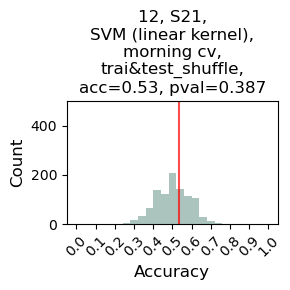

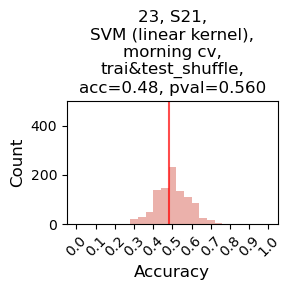

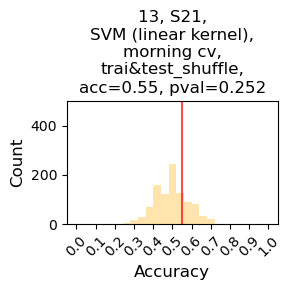

In [157]:
for i in range(3):
    plt.figure(figsize=(3,3)) 
    bin_edges = np.arange(0, 1+0.04, 0.04)
    plt.hist(acc_sh[i], bins=bin_edges, alpha=0.5, color=colors[i])
    plt.axvline(acc_svm[i],color='red', alpha=0.7)
    plt.xlabel('Accuracy', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45)
    plt.xticks(np.arange(0, 1.1, 0.1)) 
    plt.ylim(0,500)
    plt.title(f'{compared[i]}, S{Session},\nSVM (linear kernel),\nmorning cv,\ntrai&test_shuffle,\nacc={acc_svm[i]:.2f}, pval={pvals[i]:.3f}')
    plt.tight_layout()
    plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\aaa_bbb\\{compared[i]}_S{Session}_SVM.png', dpi=300, bbox_inches='tight')
    plt.show()

In [158]:
classifiers_results = {}
classifiers_results['svm'] = {'acc12':acc_svm_12, 'acc_sh12':acc_sh12, 'pval12':pvals[0], 
                              'acc23':acc_svm_23, 'acc_sh23':acc_sh23, 'pval23':pvals[1],
                              'acc13':acc_svm_13, 'acc_sh13':acc_sh13, 'pval13':pvals[2]}

In [159]:
save_path = f'C:\\Users\\ebukina\\Desktop\\eva\\results\\aaa_bbb\\{mouse}_S{Session}_classifiers_results.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(classifiers_results, f)

In [160]:
# # load
# with open(save_path, 'rb') as f:
#     classifiers_results = pickle.load(f)
# classifiers_results